## Purpose of this notebook: 
1. Obtain 30-year time series of weather data (precip, temperature) for Cotton field locations (using GridMET, PRISM)
2. Compare locations statistically - are they statistically different? similar? 
3. Look at just 2018 and 2019 data for the locations. Are these statistically similar? Are any locations very different (such that we would not want them to be part of a training or test set?)


In [12]:
from tqdm.autonotebook import tqdm
import netCDF4
import csv
import numpy as np
import re
import urllib.request
import csv
import pandas as pd
import matplotlib.pyplot as plt

import geopandas as gpd
from shapely.geometry import Point, Polygon
%matplotlib inline

from scipy import stats
import sklearn
from sklearn.metrics import mean_squared_error
import math

import pingouin as pg

#import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols

# get ANOVA table as R like output
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.multicomp as mc
import seaborn as sns

from datetime import datetime


In [13]:
## Read in Cotton Plot location metadata
meta_pd = pd.read_excel(open('CottonDataFiles/Maturity_2018_2019.xlsx', 
                             'rb'), sheet_name='location_data', 
                        header=0, usecols = "A,B,C,D,E",
                        dtype={'Year': float, 'State': str, 
                               'City': str, 'Latitude': float, 
                               'Longitude': float})  


# Remove all rows for which we have a NaN in for lat/lon
meta_pd.dropna(subset=['Latitude', 'Longitude'],inplace=True)

In [14]:
# Format the data to make joins easier
meta_pd['state_simp'] = meta_pd['State'].map(lambda x: x.rstrip('_1').rstrip('_2'))
meta_pd['lat_rnd'] = meta_pd['Latitude'].round(3).astype(str)
meta_pd['lon_rnd'] = meta_pd['Longitude'].round(3).astype(str)
meta_pd.drop_duplicates(subset=['City','state_simp'],inplace=True)
meta_pd.drop(columns=['Year'],inplace=True)

In [15]:
# Reduce our dataset to just City-States (yes, there are some sites that have diff lat/longs from the 
# same city, but they're close enough that for this analysis -- to see if how sites vary climatologyst -- it's fine)
meta_pd['id'] = meta_pd[['City','state_simp']].agg('_'.join,axis=1)

In [16]:
meta_pd.reset_index(inplace=True)
meta_pd.drop(columns="index",inplace=True)
meta_pd

State              City   Latitude   Longitude state_simp lat_rnd  \
0     TN           Jackson  35.621806  -88.844985         TN  35.622   
1     AL        Belle Mina  34.689121  -86.885839         AL  34.689   
2     AZ           Safford  32.816082 -109.680171         AZ  32.816   
3     SC          Florence  34.310577  -79.744657         SC  34.311   
4     VA           Suffolk  36.663297  -76.735938         VA  36.663   
5     MS       Brooksville  33.257822  -88.539361         MS  33.258   
6     LA        Alexandria  31.171660  -92.407300         LA  31.172   
7     TX  College Station   30.509740  -96.417900         TX   30.51   
8     GA            Tifton  31.442500  -83.586300         GA  31.442   
9     OK           Perkins  35.989510  -97.015220         OK   35.99   
10    CA           Calflax  36.342220 -120.109700         CA  36.342   
11  AL_1           Brewton  31.142301  -87.049151         AL  31.142   
12  AL_2           Shorter  32.421669  -85.885667         AL  32.422   
13    TX          New Deal  33.744442 -101.728167         TX  33.744   

     lon_rnd                   id  
0    -88.845           Jackson_TN  
1    -86.886        Belle Mina_AL  
2    -109.68           Safford_AZ  
3    -79.745          Florence_SC  
4    -76.736           Suffolk_VA  
5    -88.539       Brooksville_MS  
6    -92.407        Alexandria_LA  
7    -96.418  College Station _TX  
8    -83.586            Tifton_GA  
9    -97.015           Perkins_OK  
10   -120.11           Calflax_CA  
11   -87.049           Brewton_AL  
12   -85.886           Shorter_AL  
13  -101.728          New Deal_TX

In [17]:
# DROP GEORGIA -- NOT IN ACTUAL DATASET
#meta_pd[meta_pd['id']=='Tifton_GA']
meta_pd.drop(meta_pd[meta_pd['id']=='Tifton_GA'].index, inplace = True)
meta_pd

State              City   Latitude   Longitude state_simp lat_rnd  \
0     TN           Jackson  35.621806  -88.844985         TN  35.622   
1     AL        Belle Mina  34.689121  -86.885839         AL  34.689   
2     AZ           Safford  32.816082 -109.680171         AZ  32.816   
3     SC          Florence  34.310577  -79.744657         SC  34.311   
4     VA           Suffolk  36.663297  -76.735938         VA  36.663   
5     MS       Brooksville  33.257822  -88.539361         MS  33.258   
6     LA        Alexandria  31.171660  -92.407300         LA  31.172   
7     TX  College Station   30.509740  -96.417900         TX   30.51   
9     OK           Perkins  35.989510  -97.015220         OK   35.99   
10    CA           Calflax  36.342220 -120.109700         CA  36.342   
11  AL_1           Brewton  31.142301  -87.049151         AL  31.142   
12  AL_2           Shorter  32.421669  -85.885667         AL  32.422   
13    TX          New Deal  33.744442 -101.728167         TX  33.744   

     lon_rnd                   id  
0    -88.845           Jackson_TN  
1    -86.886        Belle Mina_AL  
2    -109.68           Safford_AZ  
3    -79.745          Florence_SC  
4    -76.736           Suffolk_VA  
5    -88.539       Brooksville_MS  
6    -92.407        Alexandria_LA  
7    -96.418  College Station _TX  
9    -97.015           Perkins_OK  
10   -120.11           Calflax_CA  
11   -87.049           Brewton_AL  
12   -85.886           Shorter_AL  
13  -101.728          New Deal_TX

# Here: Plot Locations on US Map


In [18]:
geo_sites = [Point(xy) for xy in zip(meta_pd['Longitude'],meta_pd['Latitude'])]

In [19]:
geo_df = gpd.GeoDataFrame(meta_pd,crs = 'epsg:4326', geometry = geo_sites)

In [20]:
us_map = gpd.read_file("GeoBoundaries/statep010.shp")

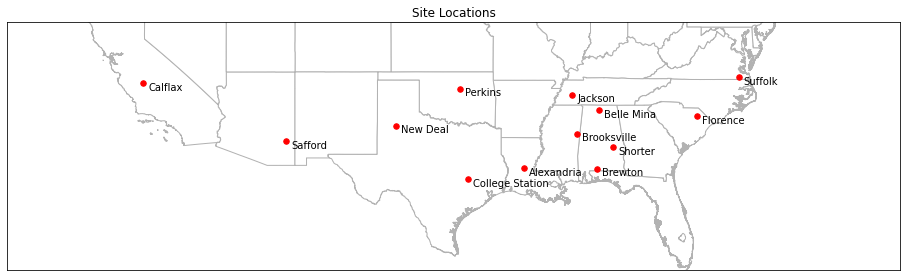

In [21]:
# Plot locations on map (zoom map to southern US, where sites are located)
fig, ax = plt.subplots(figsize=(16,10))

us_map.plot(ax=ax,edgecolor='#b2b2b2',color='white')
geo_df.plot(ax=ax,markersize=30,color="red",marker="o",label="sites")

# Sets axes limits in lat/lon
ax.set_xlim(-130,-65)
ax.set_ylim(25,40)
ax.set_title('Site Locations')
ax.tick_params(
    axis='both', bottom=False, left=False,         
    labelbottom=False, labelleft=False) 

for x, y, label in zip(geo_df.geometry.x, geo_df.geometry.y, geo_df.City):
    ax.annotate(label, xy=(x, y), xytext=(5, -7), textcoords="offset points")

In [22]:
# FUNCTION: Obtains GridMET data given input lat, lon, and year range 
#           (inputs state and indx_id are rewritten back out in dictionary to help with indexing output)
# year_min = inclusive
# year_max = inclusive
def getGRIDMET(year_min,year_max,in_lat,in_lon,state,indx_id):
        
    nlat = 585
    nlon = 1386
    min_lon = -124.7666666333333
    max_lat = 49.40000000000000
    grid_space = 0.041666666666666

    # Lat and lon grid points 
    lat_grid = round((max_lat - in_lat)/grid_space)
    lon_grid = round((in_lon - min_lon)/grid_space)
    
    rows = []
    for year in range(year_min,year_max+1):
        ndays = 364 # 0-indexed num days per year
        if((year % 4) == 0 & (year % 100) == 0 & (year % 400) == 0 ):
            ndays = ndays +1

        # tmmn = min air temp
        # tmmx = max air temp
        # pr = precipitation
        # srad = solar radiation [NOT pulling for now]
        file_var_arr = ["tmmn","tmmx","pr"]
        var_str = ["air_temperature","air_temperature","precipitation_amount"]

        for v in range(0,len(file_var_arr)):

            url_start = "http://thredds.northwestknowledge.net:8080/thredds/dodsC/MET/"
            request = var_str[v]+"[0:1:"+str(ndays)+"]["+str(lat_grid)+"]["+str(lon_grid)+"]"
            url = url_start+file_var_arr[v]+"/"+file_var_arr[v]+"_"+str(year)+".nc.ascii?"+request
            var_find_start = var_str[v]+'.'+var_str[v]
            var_find_end = var_str[v]+'.day'

            downloaded = False
            while not downloaded:
                try:
                    response = urllib.request.urlopen(url)
                    downloaded = True
                except:
                    pass
            
            read = 0
            for line in response:

                # Decode OPEnDAP output
                if line.decode('utf-8').find(var_find_start) != -1:
                    read=1
                    continue
                if line.decode('utf-8').find(var_find_end) != -1:
                    read=0        

                if(read==1):
                    curr_line = re.split(', |[]|[]|\n', line.decode('utf-8'))
                    curr_line = list(filter(None, curr_line))

                    if(len(curr_line)>0):
                        curr_day = curr_line[0]
                        curr_val = curr_line[2]
                        rows.append({'id':indx_id,'state':state,'latitude':in_lat,'longitude':in_lon,'year':year,'date':curr_day,'VarName':str(file_var_arr[v]),'Value':curr_val})
    
    return(rows)

In [23]:
# IF GOING TO QUERY FOR GRIDMET DATA, UNCOMMENT BELOW
# IF not GOING TO QUERY FOR THIS, THEN LEAVE COMMENTED (TAKES A WHILE TO RUN)

# # Now obtain GridMet Data
# all_grid_met = []
# for row in tqdm(meta_pd.itertuples()):
#     lat = row[3]
#     lon = row[4]
#     state=row[1]
#     id_val = row[8]
#     all_grid_met.append(getGRIDMET(1990,2020,lat,lon,state,id_val))

# # Write to CSV
# ids = meta_pd['id']
# s=0
# with open('MetDataFiles/GridMET_1990_2020.csv', 'w', newline='') as csvfile:
#     field_names = ['id','state','latitude','longitude','year','date', 'VarName', 'Value']
#     writer = csv.DictWriter(csvfile, fieldnames=field_names)
#     writer.writeheader()
#     for s in range(len(ids)):
#         writer.writerows(all_grid_met[s])

In [24]:
# If reading in GridMET data that's already been grabbed, read in from .csv file
df = pd.read_csv("MetDataFiles/GridMET_1990_2020.csv")
df

id state   latitude   longitude  year  date VarName  Value
0        Jackson_TN    TN  35.621806  -88.844985  1990     0    tmmn    607
1        Jackson_TN    TN  35.621806  -88.844985  1990     1    tmmn    604
2        Jackson_TN    TN  35.621806  -88.844985  1990     2    tmmn    645
3        Jackson_TN    TN  35.621806  -88.844985  1990     3    tmmn    708
4        Jackson_TN    TN  35.621806  -88.844985  1990     4    tmmn    660
...             ...   ...        ...         ...   ...   ...     ...    ...
441592  New Deal_TX    TX  33.744442 -101.728167  2020   361      pr      0
441593  New Deal_TX    TX  33.744442 -101.728167  2020   362      pr      0
441594  New Deal_TX    TX  33.744442 -101.728167  2020   363      pr      0
441595  New Deal_TX    TX  33.744442 -101.728167  2020   364      pr      8
441596  New Deal_TX    TX  33.744442 -101.728167  2020   365      pr      0

[441597 rows x 8 columns]

In [25]:
# PRISM data were obtained separately using PRISM's data explorer 
# This is a GUI interfrace where users can enter in a lat/long onto a web interface and download time series
# Since there were only 13 locations for this, and since there's not THREDDS server that provides PRISM from
# https://prism.oregonstate.edu/, this was the fastest route
prism_frames = []
for i in range(len(df.id.unique().tolist())):
    curr_df = pd.read_csv("MetDataFiles/PRISM_Data/"+df.id.unique().tolist()[i]+".csv")
    curr_df['id'] = df.id.unique().tolist()[i]
    prism_frames.append(curr_df)
df_prism = pd.concat(prism_frames)

In [26]:
df_prism.shape

(189930, 9)

In [27]:
# Remove Georgia
df_prism_copy = df_prism[df_prism['id']!='Tifton_GA']
df_prism = df_prism_copy

In [28]:
# Do some re-arranging of GridMET dataframe to make working with the data easier
wxdf = df.copy()
wxdf.insert(0, 'New_ID', range(0, len(wxdf)))

# Now pivot so that have columns for Tmin, Tmax, and Precip
wxdf_piv = wxdf.pivot(index=['id','year','date'],columns=['VarName'], values='Value')
wxdf_piv.reset_index(inplace=True)

In [29]:
# Convert Tmax and Tmin from Kelvin to Fahrenheit
# Scale Precip so units are mm 

# These scale and offsets came from NetCDF files from GridMET TDS server 
# http://thredds.northwestknowledge.net:8080/thredds/reacch_climate_MET_catalog.html
scale_factor = 0.1
offset_min = 210.0
offset_max = 220.0

wxdf_piv['tmmn_C'] = ((wxdf_piv['tmmn'] * scale_factor + offset_min))- 273.15
wxdf_piv['tmmx_C'] = ((wxdf_piv['tmmx'] * scale_factor + offset_max))- 273.15
wxdf_piv['tmmn_F'] = wxdf_piv['tmmn_C'] * (9/5) + 32
wxdf_piv['tmmx_F'] = wxdf_piv['tmmx_C'] * (9/5) + 32

wxdf_piv['pr_scaled'] = wxdf_piv['pr'] * scale_factor

In [30]:
# Compute Daily Mean Temperature (degree C only)
wxdf_piv['tmean_C'] = (wxdf_piv['tmmx_C'] + wxdf_piv['tmmn_C']) / 2
wxdf_piv

VarName             id  year  date   pr  tmmn  tmmx  tmmn_C  tmmx_C  tmmn_F  \
0        Alexandria_LA  1990     0    0   631   657   -0.05   12.55   31.91   
1        Alexandria_LA  1990     1   81   659   625    2.75    9.35   36.95   
2        Alexandria_LA  1990     2  210   706   677    7.45   14.55   45.41   
3        Alexandria_LA  1990     3  234   748   688   11.65   15.65   52.97   
4        Alexandria_LA  1990     4  198   738   679   10.65   14.75   51.17   
...                ...   ...   ...  ...   ...   ...     ...     ...     ...   
147194      Suffolk_VA  2020   361    0   585   630   -4.65    9.85   23.63   
147195      Suffolk_VA  2020   362    0   641   682    0.95   15.05   33.71   
147196      Suffolk_VA  2020   363    0   600   629   -3.15    9.75   26.33   
147197      Suffolk_VA  2020   364    0   595   661   -3.65   12.95   25.43   
147198      Suffolk_VA  2020   365  207   681   677    4.95   14.55   40.91   

VarName  tmmx_F  pr_scaled  tmean_C  
0         54.59        0.0     6.25  
1         48.83        8.1     6.05  
2         58.19       21.0    11.00  
3         60.17       23.4    13.65  
4         58.55       19.8    12.70  
...         ...        ...      ...  
147194    49.73        0.0     2.60  
147195    59.09        0.0     8.00  
147196    49.55        0.0     3.30  
147197    55.31        0.0     4.65  
147198    58.19       20.7     9.75  

[147199 rows x 12 columns]

In [31]:
# Also drop Tifton_GA from the wxdf_piv (gridMET) and df_prism (PRISM) datasets

# DROP GEORGIA -- NOT IN ACTUAL DATASET
wxdf_piv.drop(wxdf_piv[wxdf_piv['id']=='Tifton_GA'].index, inplace = True)

#meta_pd[meta_pd['id']=='Tifton_GA']
#df_prism.drop(df_prism[df_prism['id']=='Tifton_GA'].index, inplace = True)

# Here: compare PRISM and GridMET

PRISM = df_prism

GridMET = wxdf_piv

In [32]:
df_prism['yr_short'] = df_prism['Date'].astype(str).str[-2:].astype(int)

In [33]:
df_prism.reset_index(inplace=True)

In [34]:
df_prism['YEAR'] = df_prism['yr_short']+ 1900
df_prism.loc[df_prism['yr_short']<81,'YEAR'] = df_prism['yr_short']+ 2000

In [35]:
df_prism.drop(columns=['yr_short'],inplace=True)

In [36]:
df_prism

index      Date  ppt (mm)  tmin (degrees C)  tmean (degrees C)  \
0           0    1/1/81      0.00              -1.6                6.3   
1           1    1/2/81      0.00              -3.9                1.6   
2           2    1/3/81      0.00              -2.6                3.1   
3           3    1/4/81      0.00              -7.7                2.5   
4           4    1/5/81      0.00             -11.8               -6.6   
...       ...       ...       ...               ...                ...   
189925  14605  12/27/20      0.00              -3.7                8.0   
189926  14606  12/28/20      0.00               2.6               10.4   
189927  14607  12/29/20      0.00               2.1                5.8   
189928  14608  12/30/20      0.25              -0.2                9.9   
189929  14609  12/31/20      0.71              -4.8               -0.1   

        tmax (degrees C)  tdmean (degrees C)  vpdmin (hPa)  vpdmax (hPa)  \
0                   14.3                 0.4          0.15          9.51   
1                    7.2                -1.5          0.18          3.94   
2                    8.8                -5.6          1.12          7.85   
3                   12.7                -4.7          1.03          8.89   
4                   -1.3               -14.5          0.76          3.27   
...                  ...                 ...           ...           ...   
189925              19.8               -15.1          3.10         21.66   
189926              18.2                -7.4          2.94         17.70   
189927               9.5                -0.4          0.74          6.22   
189928              20.1                 3.5          0.18         15.01   
189929               4.5                -7.6          0.79          5.13   

                 id  YEAR  
0        Jackson_TN  1981  
1        Jackson_TN  1981  
2        Jackson_TN  1981  
3        Jackson_TN  1981  
4        Jackson_TN  1981  
...             ...   ...  
189925  New Deal_TX  2020  
189926  New Deal_TX  2020  
189927  New Deal_TX  2020  
189928  New Deal_TX  2020  
189929  New Deal_TX  2020  

[189930 rows x 11 columns]

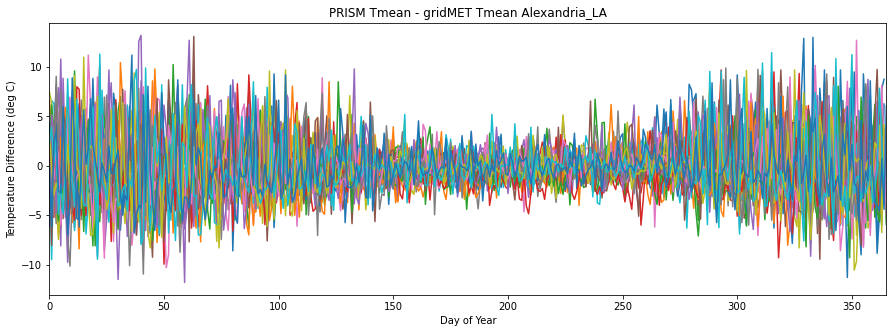

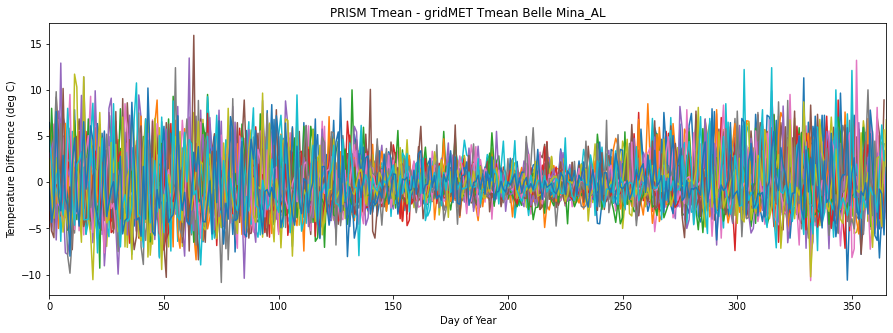

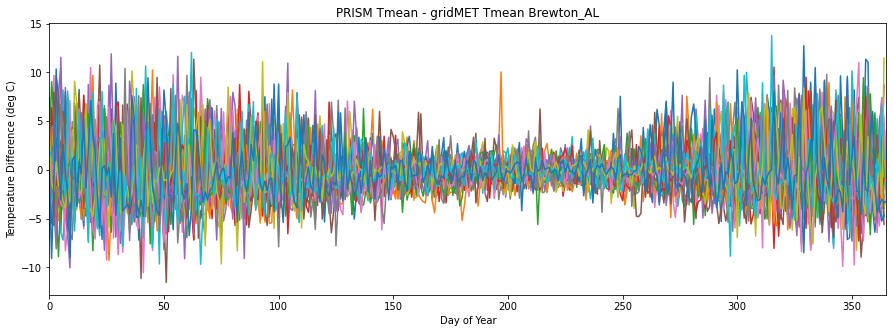

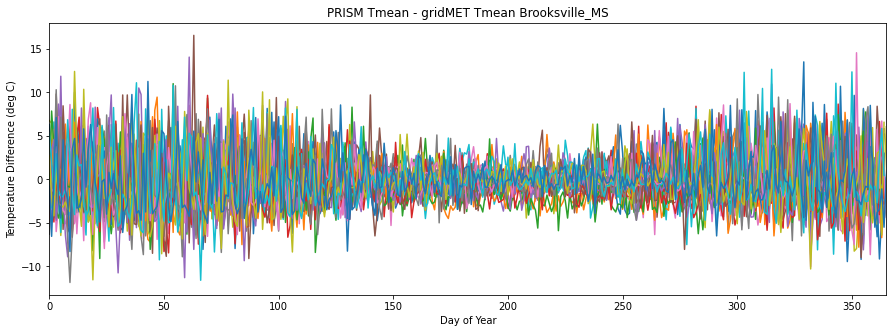

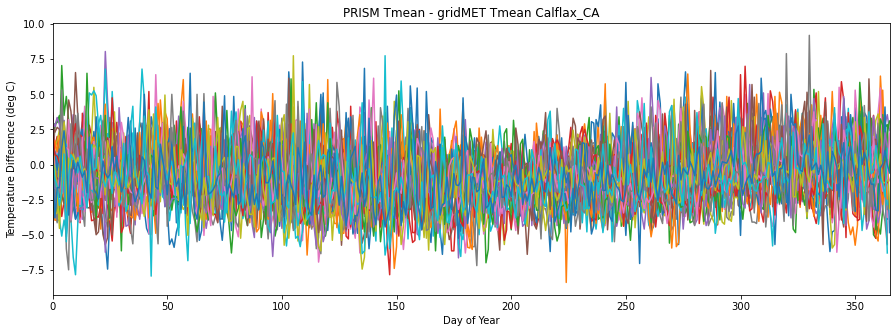

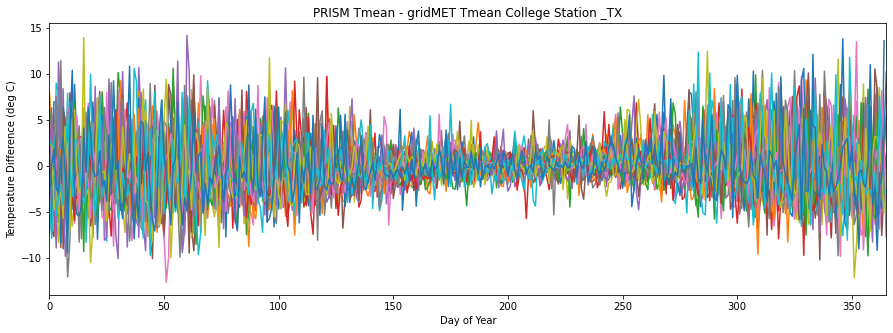

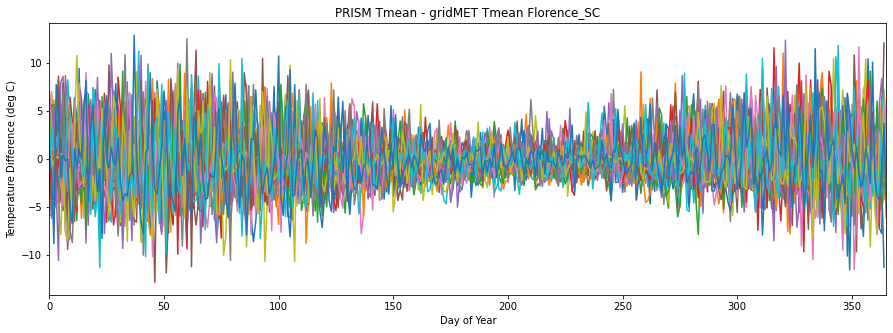

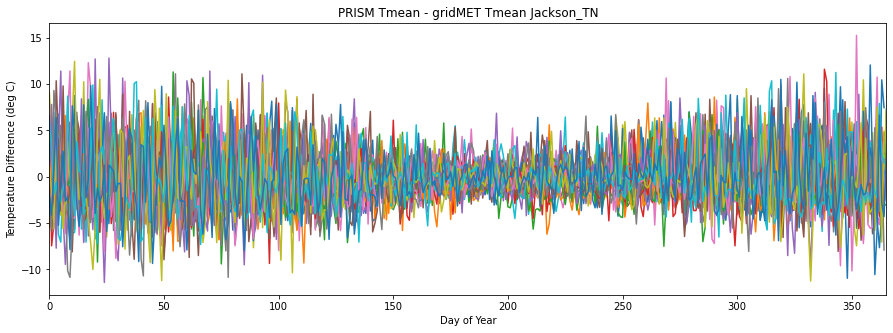

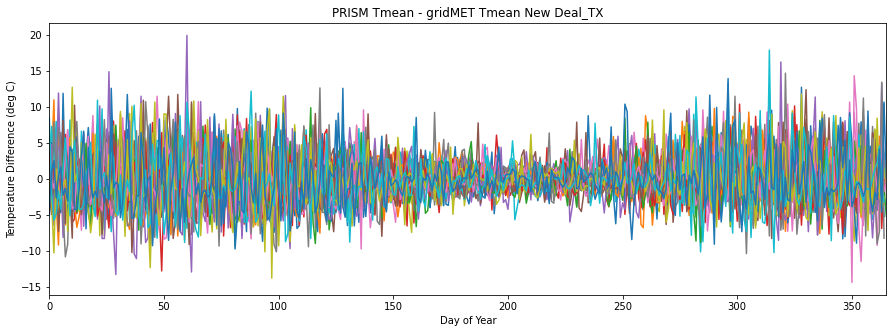

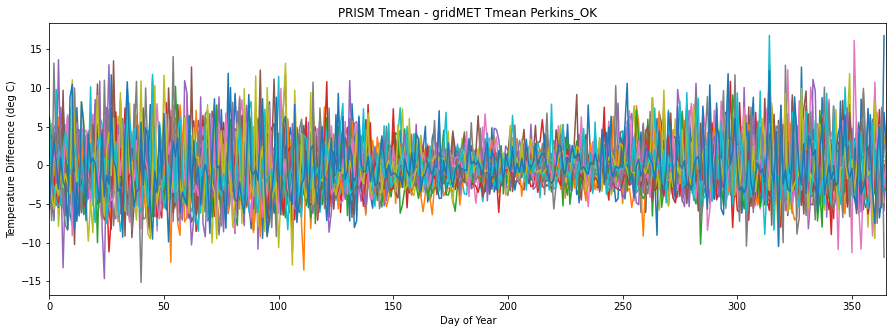

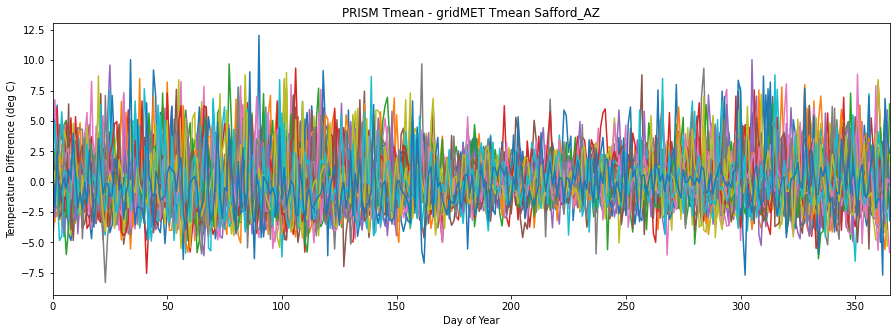

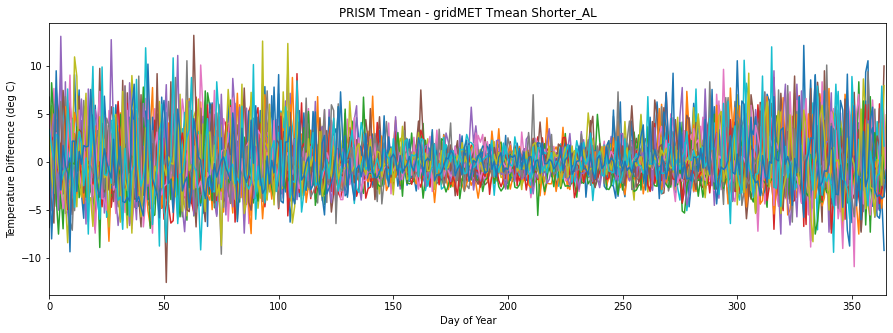

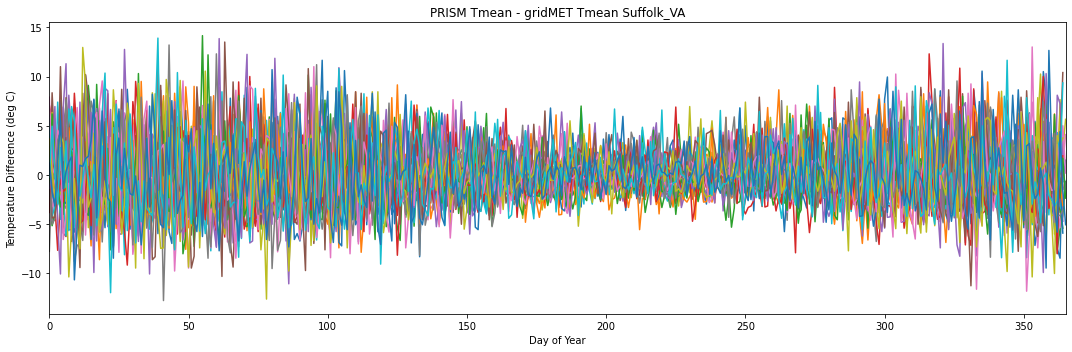

In [101]:
# Now compare gridMET and PRISM data
locs = wxdf_piv['id'].unique()
years = [y for y in range(1990,2021)]

for l in range(len(locs)):
    
    fig, ax  = plt.subplots(1,figsize=(15,5))

    all_gridmet = []
    all_prism = []
    for y in range(len(years)):
        curr_gridmet = wxdf_piv[(wxdf_piv['id']==locs[l]) & (wxdf_piv['year']==years[y])].copy()
        curr_prism = df_prism[(df_prism['id']==locs[l]) & (df_prism['YEAR']==years[y])].copy()

        curr_diff_prcp = np.array(curr_prism['ppt (mm)'].cumsum())-np.array(curr_gridmet['pr_scaled'].cumsum())

        # If want to look at minimum temperature differences, uncomment these lines
#         curr_diff_mean = np.array(curr_prism['tmin (degrees C)'])-np.array(curr_gridmet['tmmx_C'])
#         all_gridmet = all_gridmet + curr_gridmet['tmmn_C'].tolist()
#         all_prism = all_prism + curr_prism['tmin (degrees C)'].tolist() 
#         ax.set_title("PRISM Tmin - gridMET Tmin "+locs[l])

        # If want to look at maximum temperature differences, uncomment these lines
#         curr_diff_mean = np.array(curr_prism['tmax (degrees C)'])-np.array(curr_gridmet['tmmx_C'])
#         all_gridmet = all_gridmet + curr_gridmet['tmmx_C'].tolist()
#         all_prism = all_prism + curr_prism['tmax (degrees C)'].tolist()
#         ax.set_title("PRISM Tmax - gridMET Tmax "+locs[l])

        # If want to look at mean temperature differences, uncomment these lines
        curr_diff_mean = np.array(curr_prism['tmean (degrees C)'])-np.array(curr_gridmet['tmean_C'])
        all_gridmet = all_gridmet + curr_gridmet['tmean_C'].tolist()
        all_prism = all_prism + curr_prism['tmean (degrees C)'].tolist()
        ax.set_title("PRISM Tmean - gridMET Tmean "+locs[l])

        # Don't comment these
        ax.plot(np.array(curr_gridmet['date']),curr_diff_mean) # Degrees C
        #ax.plot(np.array(curr_gridmet['date']),(curr_diff_mean*9/5)) # Degrees F

        ax.set_ylabel("Temperature Difference (deg C)")
        ax.set_xlabel("Day of Year")
        ax.set_xlim([0,365])
    
#     pears_r, pears_p = stats.pearsonr(all_gridmet,all_prism)
#     print ("___________________________________________\n")
#     print(locs[l])
#     print("Pearson Correlation: ",round(pears_r,2),"(p-value =",pears_p,")")
#     tt_r,tt_p = stats.ttest_ind(all_gridmet,all_prism)
#     if(tt_p < 0.05):
#         print("T-test for means: reject null hypothesis that means are different.")
#     else:
#         print("T-test for means: Do NOT reject null hypothesis that means are different.")

#     rmse = math.sqrt(sklearn.metrics.mean_squared_error(all_gridmet,all_prism))

#     print("Root mean square difference: ",round(rmse,2), "(deg C)")


plt.tight_layout()


# Next, compare distributions across locations

In [38]:
df_prism[['mon_short','day_short','yr_short']] = df_prism['Date'].str.split('/',expand=True)
df_prism

index      Date  ppt (mm)  tmin (degrees C)  tmean (degrees C)  \
0           0    1/1/81      0.00              -1.6                6.3   
1           1    1/2/81      0.00              -3.9                1.6   
2           2    1/3/81      0.00              -2.6                3.1   
3           3    1/4/81      0.00              -7.7                2.5   
4           4    1/5/81      0.00             -11.8               -6.6   
...       ...       ...       ...               ...                ...   
189925  14605  12/27/20      0.00              -3.7                8.0   
189926  14606  12/28/20      0.00               2.6               10.4   
189927  14607  12/29/20      0.00               2.1                5.8   
189928  14608  12/30/20      0.25              -0.2                9.9   
189929  14609  12/31/20      0.71              -4.8               -0.1   

        tmax (degrees C)  tdmean (degrees C)  vpdmin (hPa)  vpdmax (hPa)  \
0                   14.3                 0.4          0.15          9.51   
1                    7.2                -1.5          0.18          3.94   
2                    8.8                -5.6          1.12          7.85   
3                   12.7                -4.7          1.03          8.89   
4                   -1.3               -14.5          0.76          3.27   
...                  ...                 ...           ...           ...   
189925              19.8               -15.1          3.10         21.66   
189926              18.2                -7.4          2.94         17.70   
189927               9.5                -0.4          0.74          6.22   
189928              20.1                 3.5          0.18         15.01   
189929               4.5                -7.6          0.79          5.13   

                 id  YEAR mon_short day_short yr_short  
0        Jackson_TN  1981         1         1       81  
1        Jackson_TN  1981         1         2       81  
2        Jackson_TN  1981         1         3       81  
3        Jackson_TN  1981         1         4       81  
4        Jackson_TN  1981         1         5       81  
...             ...   ...       ...       ...      ...  
189925  New Deal_TX  2020        12        27       20  
189926  New Deal_TX  2020        12        28       20  
189927  New Deal_TX  2020        12        29       20  
189928  New Deal_TX  2020        12        30       20  
189929  New Deal_TX  2020        12        31       20  

[189930 rows x 14 columns]

In [39]:
df_prism['mon_full'] = df_prism['mon_short']
df_prism.loc[df_prism['mon_short'].map(int)<10,'mon_full'] = "0"+df_prism['mon_short'].map(str)

df_prism['day_full'] = df_prism['day_short']
df_prism.loc[df_prism['day_short'].map(int)<10,'day_full'] = "0"+df_prism['day_short'].map(str)

df_prism.drop(columns=['mon_short','day_short','yr_short'],inplace=True)

In [40]:
df_prism['long_date'] = df_prism['YEAR'].map(str)+"-"+df_prism['mon_full'].map(str)+"-"+df_prism['day_full'].map(str)

In [41]:
df_prism['DayofYear'] = df_prism['long_date'].apply(lambda x: datetime.strptime(str(x), '%Y-%m-%d').timetuple().tm_yday-1)

In [42]:
# Write combined PRISM data out to File
df_prism.to_csv('MetDataFiles/PRISM_1981_2020.csv')

In [89]:
df_prism['tmin (degrees F)'] = (df_prism['tmin (degrees C)'] * 9/5) + 32
df_prism['tmax (degrees F)'] = (df_prism['tmax (degrees C)'] * 9/5) + 32
df_prism['tmean (degrees F)'] = (df_prism['tmean (degrees C)'] * 9/5) + 32
df_prism['ppt (in)'] = df_prism['ppt (mm)'] / 25.4


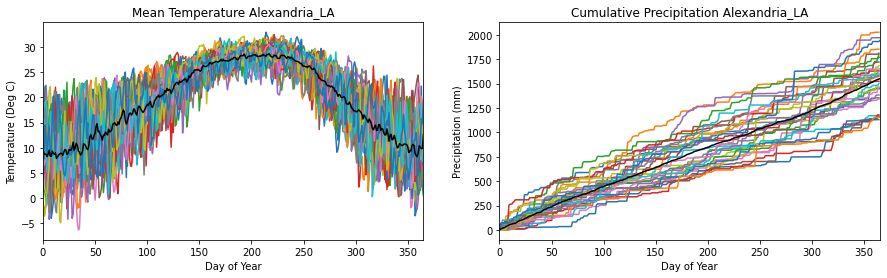

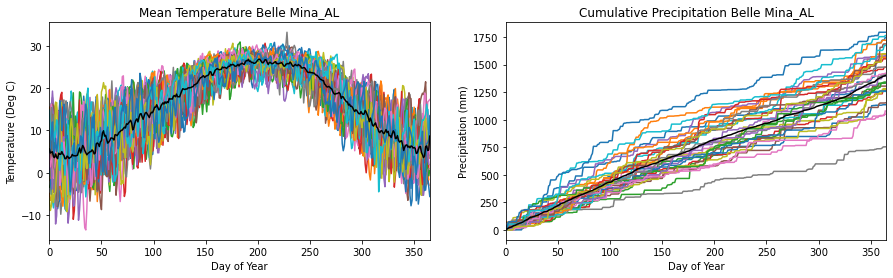

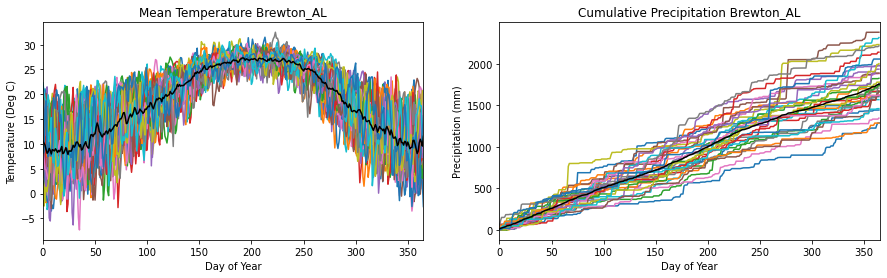

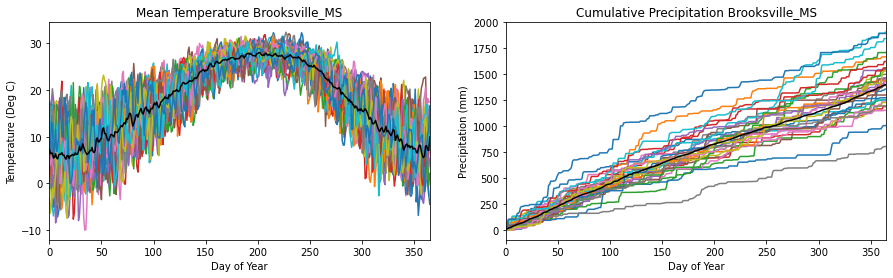

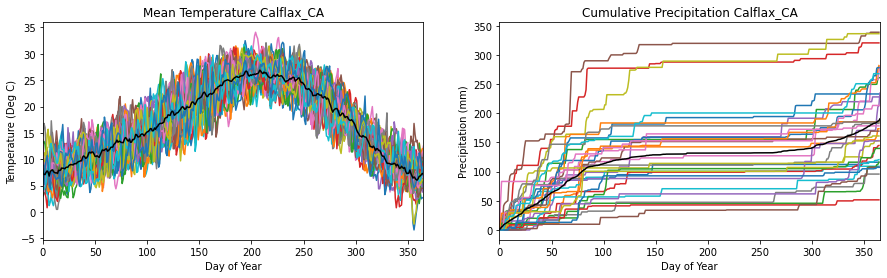

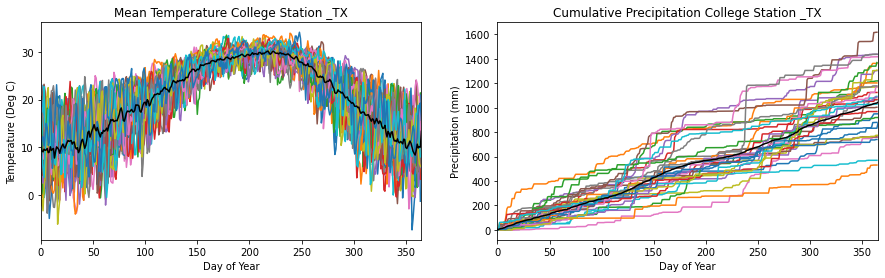

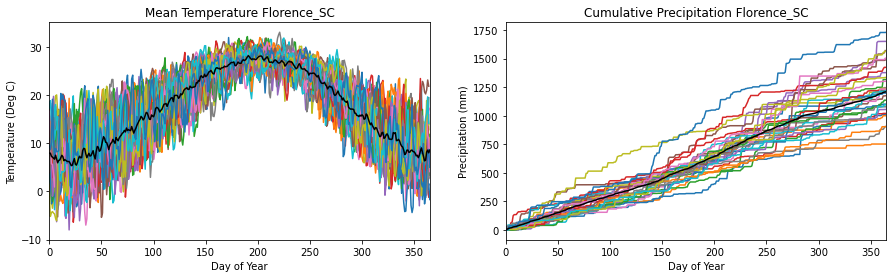

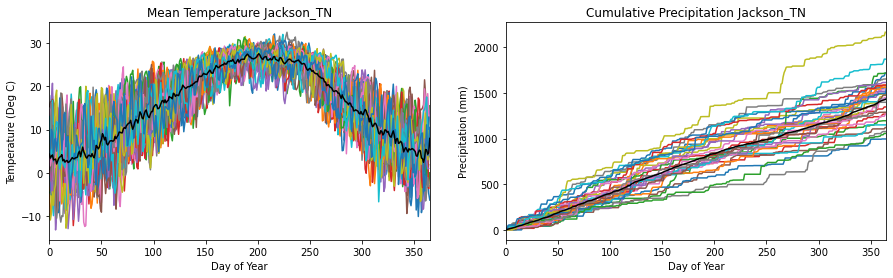

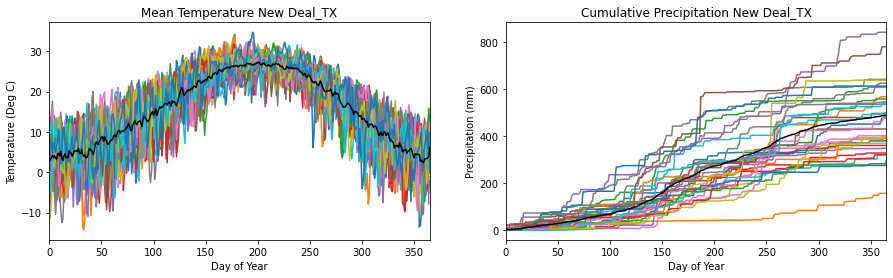

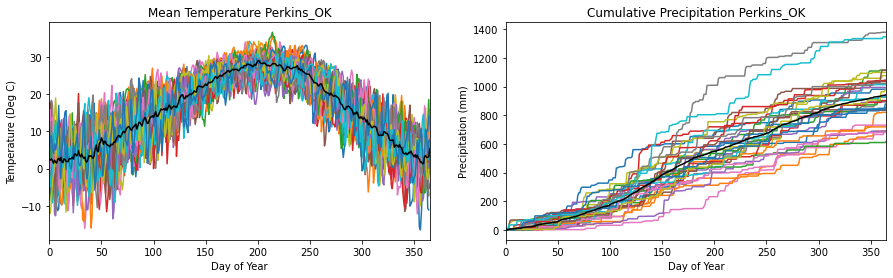

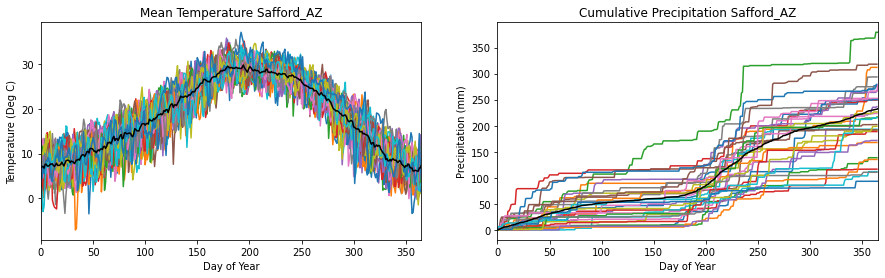

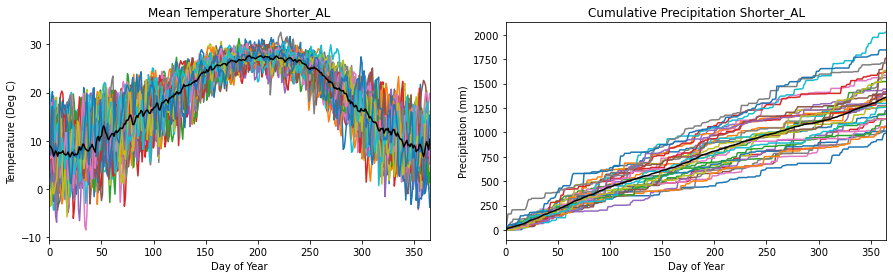

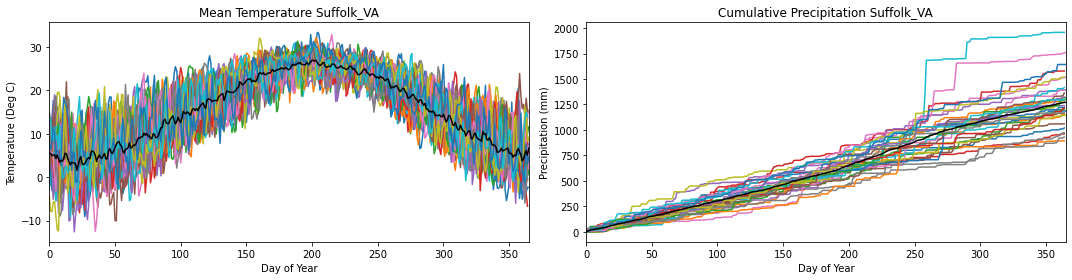

In [104]:
years = [y for y in range(1990,2021)]

for l in range(len(locs)):
    
    fig, ax  = plt.subplots(1,2,figsize=(15,4))

    # Using gridMET
    #avg_vals = wxdf_piv[(wxdf_piv['id']==locs[l])].groupby('date').mean()
    
    # Using PRISM
    avg_vals = df_prism[(df_prism['id']==locs[l])].groupby('DayofYear').mean()

    for y in range(len(years)):
        # Using gridMET
        #curr_vals = wxdf_piv[(wxdf_piv['id']==locs[l]) & (wxdf_piv['year']==years[y])]
        
        # Using PRISM
        curr_vals = df_prism[(df_prism['id']==locs[l]) & (df_prism['YEAR']==years[y])]

        # Day of year column id:
        #date_col = 'date' # gridMET
        date_col = 'DayofYear' # PRISM
        
        # Var to look at:
        #temp_var = 'tmean_C' # gridMET
        temp_var = 'tmean (degrees C)' #PRISM
        # prcp_var = 'pr' # gridMET
        prcp_var = 'ppt (mm)' # PRISM
        
        ax[0].plot(np.array(curr_vals[date_col]),
                   np.array(curr_vals[temp_var]))
        ax[1].plot(np.array(curr_vals[date_col]),
                   np.array(curr_vals[prcp_var].cumsum()))
        # ax[0].set_title("gridMET Tmean "+locs[l]) # gridMET
        ax[0].set_title("Mean Temperature "+locs[l]) # PRISM
        ax[1].set_title("Cumulative Precipitation "+locs[l])

    ax[0].plot(np.array([d for d in range(0,366)]),avg_vals[temp_var],color="black")
    ax[1].plot(np.array([d for d in range(0,366)]),avg_vals[prcp_var].cumsum(),color="black")
    ax[0].set_xlim([0,365])
    ax[1].set_xlim([0,365])
    ax[0].set_xlabel('Day of Year')
    ax[1].set_xlabel('Day of Year')
    ax[0].set_ylabel('Temperature (Deg C)')
    ax[1].set_ylabel('Precipitation (mm)')
plt.tight_layout()

In [92]:
#avg_of_all = wxdf_piv.groupby(['id','date']).mean()
#avg_of_all.reset_index(inplace=True)

avg_of_all = df_prism.groupby(['id','DayofYear']).mean()
avg_of_all.reset_index(inplace=True)

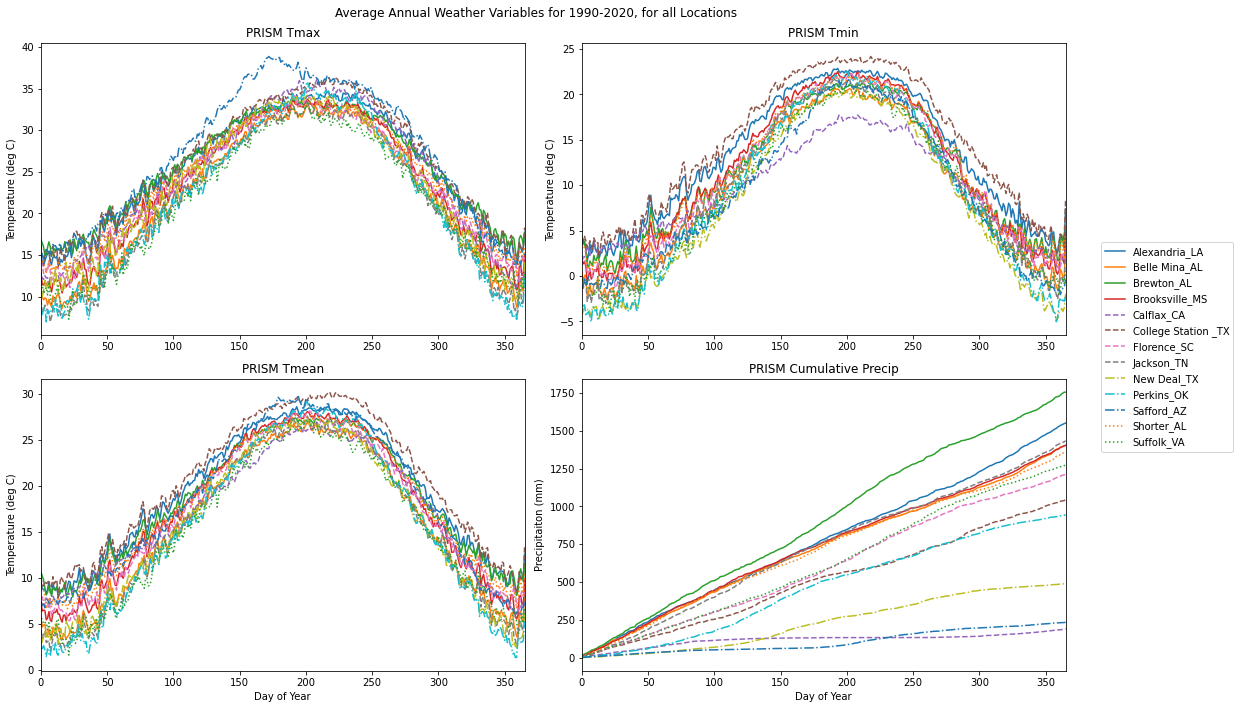

In [105]:
# Get mean wx by day of year
tmmn_list = {}
tmmx_list = {}
tmean_list = {}
cum_prcp_list = {}

# Variables -- based on whether we're doing PRISM or gridMET
#tmax_var = 'tmmx_C' # gridMET
#tmin_var = 'tmmn_C' # gridMET
#tmean_var = 'tmean_C' # gridMET
#prcp_var = 'pr' # gridMET
#day_var = 'date'
#year_var = 'year'
#source = "gridMET"
tmax_var = 'tmax (degrees C)' # PRISM
tmin_var = 'tmin (degrees C)' # PRISM
tmean_var = 'tmean (degrees C)' # PRISM
prcp_var = 'ppt (mm)' # PRISM
day_var = 'DayofYear'
source = "PRISM"
year_var = 'YEAR'

line_styles = ['-','-','-','-','--','--','--','--','-.','-.','-.',':',':']

fig, ax  = plt.subplots(2,2,figsize=(15,10))
for l in range(len(locs)):
    curr_vals = avg_of_all[(avg_of_all['id']==locs[l]) & (avg_of_all[year_var]>=1991)]
    
    ax[0][0].plot(np.array(curr_vals[day_var]),
               np.array(curr_vals[tmax_var]),line_styles[l])
    ax[0][0].set_xlim([0, 365])
    ax[0][1].plot(np.array(curr_vals[day_var]),
               np.array(curr_vals[tmin_var]),line_styles[l])
    ax[0][1].set_xlim([0, 365])
    ax[0][0].set_title(source+" Tmax")
    ax[0][1].set_title(source+" Tmin")
    
    ax[1][0].plot(np.array(curr_vals[day_var]),
               np.array((curr_vals[tmean_var])),line_styles[l])
    ax[1][0].set_xlim([0, 365])
    ax[1][1].plot(np.array(curr_vals[day_var]),
               np.array(curr_vals[prcp_var].cumsum()),line_styles[l])
    ax[1][1].set_xlim([0, 365])
    ax[1][0].set_title(source+" Tmean")
    ax[1][1].set_title(source+" Cumulative Precip")
    
    ax[0][0].set_ylabel('Temperature (deg C)')
    ax[0][1].set_ylabel('Temperature (deg C)')
    ax[1][0].set_ylabel('Temperature (deg C)')
    ax[1][1].set_ylabel('Precipitaiton (mm)')
    ax[1][0].set_xlabel('Day of Year')
    ax[1][1].set_xlabel('Day of Year')
    
    
    tmmn_list[locs[l]] = np.array(curr_vals[tmin_var])
    tmmx_list[locs[l]] = np.array(curr_vals[tmax_var])
    tmean_list[locs[l]] = np.array(curr_vals[tmean_var])
    cum_prcp_list[locs[l]] = np.array(curr_vals[prcp_var].cumsum())
    
plt.suptitle('Average Annual Weather Variables for 1990-2020, for all Locations')
plt.tight_layout()
fig.legend(bbox_to_anchor=(1.15, 0.66),labels=locs)


## Next: Statistically compare temperature (and precipitation) across locations

In [46]:
tmmn_df = pd.DataFrame(tmmn_list)
tmmx_df = pd.DataFrame(tmmx_list)
tmean_df = pd.DataFrame(tmean_list)
cum_prcp_df = pd.DataFrame(cum_prcp_list)

In [47]:
# print("Minimum Temperature Correlations")
# display(tmmn_df.rcorr())

# print("Maximum Temperature Correlations")
# display(tmmx_df.rcorr())

print("Mean Temperature Correlations")
display(tmean_df.rcorr())

print("\n______________________________________________________")
print("Cumulative Precipitation Correlations")
display(cum_prcp_df.rcorr())

Mean Temperature Correlations


Alexandria_LA Belle Mina_AL Brewton_AL Brooksville_MS  \
Alexandria_LA                   -           ***        ***            ***   
Belle Mina_AL               0.998             -        ***            ***   
Brewton_AL                  0.998         0.998          -            ***   
Brooksville_MS              0.999         0.999      0.999              -   
Calflax_CA                  0.987         0.985      0.986          0.986   
College Station _TX         0.998         0.996      0.995          0.997   
Florence_SC                 0.995         0.998      0.997          0.997   
Jackson_TN                  0.998         0.999      0.997          0.999   
New Deal_TX                 0.995         0.994      0.992          0.995   
Perkins_OK                  0.995         0.996      0.994          0.996   
Safford_AZ                  0.992         0.992      0.992          0.992   
Shorter_AL                  0.998         0.999        1.0          0.999   
Suffolk_VA                  0.991         0.995      0.994          0.993   

                    Calflax_CA College Station _TX Florence_SC Jackson_TN  \
Alexandria_LA              ***                 ***         ***        ***   
Belle Mina_AL              ***                 ***         ***        ***   
Brewton_AL                 ***                 ***         ***        ***   
Brooksville_MS             ***                 ***         ***        ***   
Calflax_CA                   -                 ***         ***        ***   
College Station _TX      0.988                   -         ***        ***   
Florence_SC              0.985               0.992           -        ***   
Jackson_TN               0.985               0.996       0.996          -   
New Deal_TX              0.988               0.995       0.992      0.995   
Perkins_OK                0.99               0.996       0.993      0.997   
Safford_AZ               0.994               0.992       0.991      0.991   
Shorter_AL               0.987               0.995       0.997      0.998   
Suffolk_VA               0.983                0.99       0.998      0.994   

                    New Deal_TX Perkins_OK Safford_AZ Shorter_AL Suffolk_VA  
Alexandria_LA               ***        ***        ***        ***        ***  
Belle Mina_AL               ***        ***        ***        ***        ***  
Brewton_AL                  ***        ***        ***        ***        ***  
Brooksville_MS              ***        ***        ***        ***        ***  
Calflax_CA                  ***        ***        ***        ***        ***  
College Station _TX         ***        ***        ***        ***        ***  
Florence_SC                 ***        ***        ***        ***        ***  
Jackson_TN                  ***        ***        ***        ***        ***  
New Deal_TX                   -        ***        ***        ***        ***  
Perkins_OK                0.997          -        ***        ***        ***  
Safford_AZ                0.996      0.995          -        ***        ***  
Shorter_AL                0.993      0.995      0.992          -        ***  
Suffolk_VA                0.989      0.992      0.989      0.995          -


______________________________________________________
Cumulative Precipitation Correlations


Alexandria_LA Belle Mina_AL Brewton_AL Brooksville_MS  \
Alexandria_LA                   -           ***        ***            ***   
Belle Mina_AL               0.999             -        ***            ***   
Brewton_AL                  0.997         0.997          -            ***   
Brooksville_MS              0.998           1.0      0.997              -   
Calflax_CA                  0.894         0.908      0.881           0.91   
College Station _TX         0.998         0.996      0.995          0.995   
Florence_SC                 0.996         0.993      0.998          0.993   
Jackson_TN                  0.998           1.0      0.997          0.999   
New Deal_TX                 0.986         0.983      0.991          0.982   
Perkins_OK                  0.993         0.993      0.996          0.992   
Safford_AZ                  0.969         0.959      0.972          0.958   
Shorter_AL                  0.998           1.0      0.998            1.0   
Suffolk_VA                  0.995         0.992      0.997          0.991   

                    Calflax_CA College Station _TX Florence_SC Jackson_TN  \
Alexandria_LA              ***                 ***         ***        ***   
Belle Mina_AL              ***                 ***         ***        ***   
Brewton_AL                 ***                 ***         ***        ***   
Brooksville_MS             ***                 ***         ***        ***   
Calflax_CA                   -                 ***         ***        ***   
College Station _TX      0.878                   -         ***        ***   
Florence_SC              0.858               0.995           -        ***   
Jackson_TN               0.901               0.996       0.993          -   
New Deal_TX               0.82               0.991       0.995      0.986   
Perkins_OK               0.858               0.996       0.995      0.995   
Safford_AZ               0.789               0.968       0.982      0.957   
Shorter_AL               0.907               0.994       0.994      0.999   
Suffolk_VA               0.854               0.996         1.0      0.992   

                    New Deal_TX Perkins_OK Safford_AZ Shorter_AL Suffolk_VA  
Alexandria_LA               ***        ***        ***        ***        ***  
Belle Mina_AL               ***        ***        ***        ***        ***  
Brewton_AL                  ***        ***        ***        ***        ***  
Brooksville_MS              ***        ***        ***        ***        ***  
Calflax_CA                  ***        ***        ***        ***        ***  
College Station _TX         ***        ***        ***        ***        ***  
Florence_SC                 ***        ***        ***        ***        ***  
Jackson_TN                  ***        ***        ***        ***        ***  
New Deal_TX                   -        ***        ***        ***        ***  
Perkins_OK                0.996          -        ***        ***        ***  
Safford_AZ                0.974      0.962          -        ***        ***  
Shorter_AL                0.984      0.993       0.96          -        ***  
Suffolk_VA                0.995      0.994      0.985      0.992          -

In [48]:
# Get mean wx, by year
# gridMET
# avg_by_yr = wxdf_piv.groupby(['id','year']).mean()
# avg_by_yr_prcp = wxdf_piv.groupby(['id','year']).sum()

# # Replace avg daily precip with total end-of-year precip
# avg_by_yr['pr'] = avg_by_yr_prcp['pr']

# # Reset indices
# avg_by_yr.reset_index(inplace=True)


# PRISM
avg_by_yr = df_prism[df_prism['YEAR']>=1991].groupby(['id','YEAR']).mean()
avg_by_yr_prcp = df_prism[df_prism['YEAR']>=1991].groupby(['id','YEAR']).sum()

# Replace avg daily precip with total end-of-year precip
avg_by_yr['ppt (mm)'] = avg_by_yr_prcp['ppt (mm)']

# Reset indices
avg_by_yr.reset_index(inplace=True)


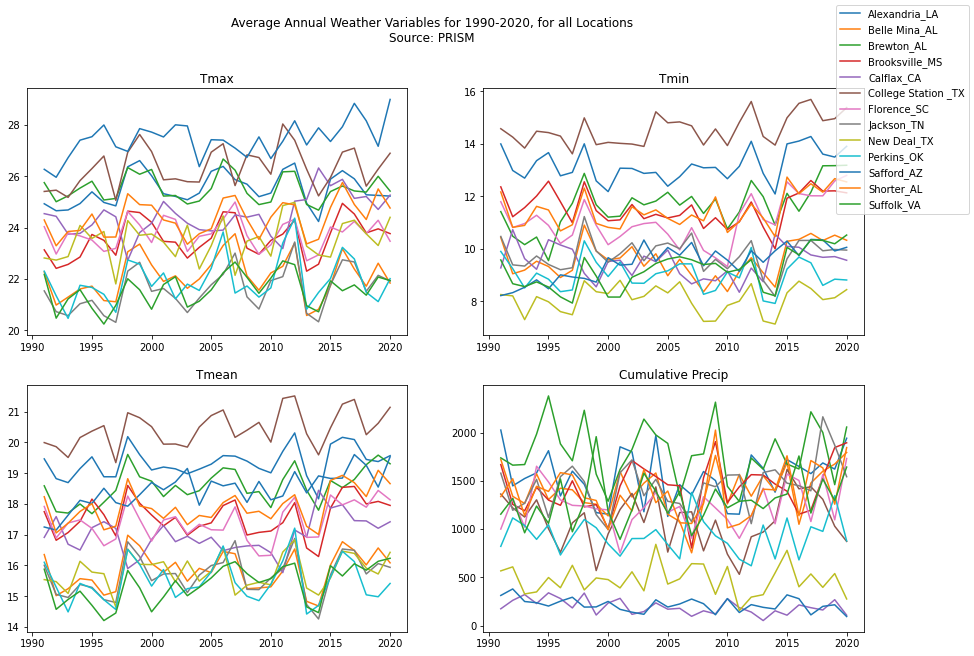

In [49]:
# Graph (and pull out) series of annual temp and precip for each location
tmmn_yrs_list = {}
tmmx_yrs_list = {}
tmean_yrs_list = {}
prcp_yrs_list = {}

loc_list = avg_by_yr['id'].unique().tolist()

fig, ax  = plt.subplots(2,2,figsize=(15,10))
for l in range(0,len(loc_list)):
    curr_vals = avg_by_yr[avg_by_yr['id']==loc_list[l]].copy()

    ax[0][0].plot(np.array(curr_vals[year_var]),np.array(curr_vals[tmax_var]))
    ax[0][0].set_title("Tmax")

    ax[0][1].plot(np.array(curr_vals[year_var]),np.array(curr_vals[tmin_var]))
    ax[0][1].set_title("Tmin")
    
    ax[1][0].plot(np.array(curr_vals[year_var]),np.array((curr_vals[tmin_var] + curr_vals[tmax_var])/2))
    ax[1][0].set_title("Tmean")

    ax[1][1].plot(np.array(curr_vals[year_var]),np.array(curr_vals[prcp_var]))
    ax[1][1].set_title("Cumulative Precip")
    
    tmmn_yrs_list[loc_list[l]] = np.array(curr_vals[tmin_var])
    tmmx_yrs_list[loc_list[l]] = np.array(curr_vals[tmax_var])
    tmean_yrs_list[loc_list[l]] = np.array((curr_vals[tmax_var] + curr_vals[tmin_var])/2)
    prcp_yrs_list[loc_list[l]] = np.array(curr_vals[prcp_var])
    
plt.suptitle('Average Annual Weather Variables for 1990-2020, for all Locations\nSource: '+source)
fig.legend(labels=locs)

In [50]:
# Put annual series into dataframes
tmmn_ann_df = pd.DataFrame(tmmn_yrs_list)
tmmx_ann_df = pd.DataFrame(tmmx_yrs_list)
tmean_ann_df = pd.DataFrame(tmean_yrs_list)
prcp_ann_df = pd.DataFrame(prcp_yrs_list)

In [51]:
unique_locs = loc_list

What these graphs show: Distribution of values over 1990-2020 period for each plot location


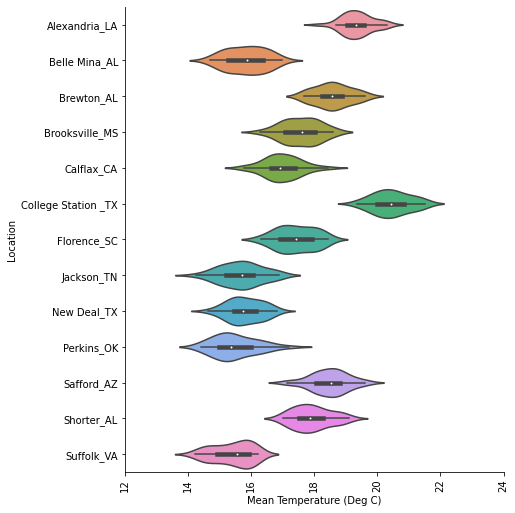

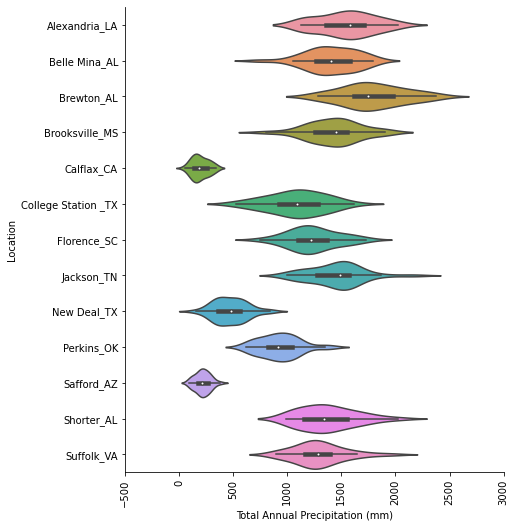

In [52]:
print("What these graphs show: Distribution of values over 1990-2020 period for each plot location")
# g = sns.catplot(x="variable", y="value", data=tmmn_ann_df.melt(), dodge=True, kind='violin', aspect=3)
# g.set_xticklabels(rotation=90)
# g.set_ylabels("Minimum Temperature (Deg C)")
# g.set_xlabels("Location")

# h = sns.catplot(x="variable", y="value", data=tmmx_ann_df.melt(), dodge=True, kind='violin', aspect=3)
# h.set_xticklabels(rotation=90)
# h.set_ylabels("Maximum Temperature (Deg C)")
# h.set_xlabels("Location")

k = sns.catplot(x="value", y="variable", data=tmean_ann_df.melt(), dodge=True, kind='violin', aspect=1, 
                orient='h',scale="width",height=7)
k.set_xticklabels(rotation=90)
k.set_xlabels("Mean Temperature (Deg C)")
k.set_ylabels("Location")

j = sns.catplot(x="value", y="variable", data=prcp_ann_df.melt(), dodge=True, kind='violin', aspect=1, 
                orient='h', height=7,scale="width")
j.set_xticklabels(rotation=90)
j.set_xlabels("Total Annual Precipitation (mm)")
j.set_ylabels("Location");



In [53]:
# Test for normality
print("Testing Annual Precipitation Datasets for Each Location for Normality")
display(pg.normality(prcp_ann_df.melt(),dv='value',group='variable'))

print("Testing Annual Mean Temperature Datasets for Each Location for Normality")
display(pg.normality(tmean_ann_df.melt(),dv='value',group='variable'))

Testing Annual Precipitation Datasets for Each Location for Normality


W      pval  normal
Alexandria_LA        0.956218  0.247215    True
Belle Mina_AL        0.967902  0.483476    True
Brewton_AL           0.975756  0.704988    True
Brooksville_MS       0.974587  0.670551    True
Calflax_CA           0.962103  0.350180    True
College Station _TX  0.982196  0.880457    True
Florence_SC          0.983507  0.909117    True
Jackson_TN           0.949924  0.168266    True
New Deal_TX          0.976903  0.738608    True
Perkins_OK           0.954967  0.229188    True
Safford_AZ           0.981408  0.861642    True
Shorter_AL           0.961199  0.332302    True
Suffolk_VA           0.957205  0.262333    True

Testing Annual Mean Temperature Datasets for Each Location for Normality


W      pval  normal
Alexandria_LA        0.971339  0.576433    True
Belle Mina_AL        0.971140  0.570824    True
Brewton_AL           0.965012  0.413052    True
Brooksville_MS       0.975053  0.684281    True
Calflax_CA           0.985863  0.950951    True
College Station _TX  0.977556  0.757515    True
Florence_SC          0.961516  0.338493    True
Jackson_TN           0.981981  0.875428    True
New Deal_TX          0.978939  0.796686    True
Perkins_OK           0.959421  0.299379    True
Safford_AZ           0.980128  0.828936    True
Shorter_AL           0.960874  0.326058    True
Suffolk_VA           0.923646  0.033381   False

In [54]:
# Test for normality
print("Testing Annual Precipitation Datasets for Equal Variance")
display(pg.homoscedasticity(prcp_ann_df[unique_locs],alpha=.05))

print("Testing Annual Mean Temperature Datasets for Equal Variance")
display(pg.homoscedasticity(tmean_ann_df[unique_locs],alpha=.05))



Testing Annual Precipitation Datasets for Equal Variance


W      pval  equal_var
levene  0.433954  0.995885       True

Testing Annual Mean Temperature Datasets for Equal Variance


W  pval  equal_var
levene  0.161841   1.0       True

In [55]:
# Compute ANOVA for precipitation data (all are normally distributed with equal variances,
# so use regular, parametric ANOVA)
print("\n\n___________________________________________________________________")
print("PRECIPITATION")
aov = pg.anova(dv='value', between='variable', data=prcp_ann_df.melt(), detailed=True)
# Pretty printing of ANOVA summary
pg.print_table(aov)
print("**RESULT: We REJECT the null hypothesis that the mean annual precipitation is the same across all locations.**")
print("\n")

# Data for at least two locations (both Perkins, OK [which are actualy exactly same location - need to reduce this])
# do not pass test for normality (all locations do pas test for equal variances)
# So, run non-paramteric test (Kruskal)
#aov = pg.kruskal(dv='value', between='variable', data=tmean_ann_df.melt())
aov = pg.anova(dv='value', between='variable', data=tmean_ann_df.melt())
# Pretty printing of ANOVA summary
print("___________________________________________________________________")
print("MEAN TEMPERATURE")
print("Non-parametric One-Way Kruskal ANOVA\n")
pg.print_table(aov)
print("**RESULT: We REJECT the null hypothesis that the mean annual temperature is the same across all locations.**")


print("___________________________________________________________________")
print("Explanation of terms:")
print("np2 = partial eta-square effect sizes \np-unc=uncorrect p=values")



___________________________________________________________________
PRECIPITATION

ANOVA SUMMARY

Source              SS    DF           MS        F    p-unc      np2
--------  ------------  ----  -----------  -------  -------  -------
variable  94606896.574    12  7883908.048  157.167    0.000    0.833
Within    18911294.835   377    50162.586  nan      nan      nan

**RESULT: We REJECT the null hypothesis that the mean annual precipitation is the same across all locations.**


___________________________________________________________________
MEAN TEMPERATURE
Non-parametric One-Way Kruskal ANOVA


ANOVA SUMMARY

Source      ddof1    ddof2        F    p-unc    np2
--------  -------  -------  -------  -------  -----
variable       12      377  224.063    0.000  0.877

**RESULT: We REJECT the null hypothesis that the mean annual temperature is the same across all locations.**
___________________________________________________________________
Explanation of terms:
np2 = partial eta-s

In [57]:
# posthocs_prcp = pg.pairwise_ttests(dv='value', between='variable', data=prcp_ann_df.melt(), parametric=True, 
#                               effsize='r',padjust='bonf').round(3)
# #pg.print_table(posthocs)
# display(posthocs_prcp)

posthocs_tmean = pg.pairwise_ttests(dv='value', between='variable', data=tmean_ann_df.melt(), parametric=False, 
                              effsize='r',padjust='bonf').round(3)
pg.print_table(posthocs_tmean)
#display(posthocs_tmean)


POST HOC TESTS

Contrast    A                    B                    Paired    Parametric      U-val  Tail         p-unc    p-corr  p-adjust         r
----------  -------------------  -------------------  --------  ------------  -------  ---------  -------  --------  ----------  ------
variable    Alexandria_LA        Belle Mina_AL        False     False         900.000  two-sided    0.000     0.000  bonf         0.820
variable    Alexandria_LA        Brewton_AL           False     False         761.000  two-sided    0.000     0.000  bonf         0.660
variable    Alexandria_LA        Brooksville_MS       False     False         897.000  two-sided    0.000     0.000  bonf         0.844
variable    Alexandria_LA        Calflax_CA           False     False         899.000  two-sided    0.000     0.000  bonf        -0.169
variable    Alexandria_LA        College Station _TX  False     False          68.000  two-sided    0.000     0.000  bonf         0.783
variable    Alexandria_LA      

In [ ]:
posthocs_tmean.reset_index(inplace=True)

# Going to try clustering

In [ ]:
# k-means clustering
from numpy import unique
from numpy import where
from sklearn.datasets import make_classification
from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift
from sklearn.datasets import make_classification
from sklearn.mixture import GaussianMixture
from sklearn.cluster import Birch
from matplotlib import pyplot

In [ ]:
#dist(tmean_ann_df.melt(),method="manhattan")

# define the model
model = KMeans(n_clusters=3)
#model=MeanShift()
#model = GaussianMixture(n_components=2)
#model = Birch(threshold=0.01, n_clusters=2)

# fit the model
model.fit(tmean_ann_df.T)
# assign a cluster to each example
yhat = model.predict(tmean_ann_df.T)

# retrieve unique clusters
clusters = unique(yhat)

# Plot distributions again - this time color-coded by cluster
cluster_colors = ['#1b9e77','#d95f02','#7570b3','#e7298a','#66a61e','#7fc97f','#e6ab02']

col_arr = ['black' for n in range(len(tmean_ann_df.T))]
for cluster in clusters:
    # get row indexes for samples with this cluster
    row_ix = where(yhat == cluster)
    cols = np.array(row_ix)[0].tolist()
    for i in range(len(cols)):
        col_arr[cols[i]] = cluster_colors[cluster]

k = sns.catplot(x="value", y="variable", data=tmean_ann_df.melt(), dodge=True, kind='violin', aspect=1, 
                orient='h',scale="width",height=7,palette=col_arr)
k.set_xticklabels(rotation=90)
k.set_xlabels("Mean Temperature (Deg C)")
k.set_ylabels("Location");


In [ ]:
geo_df

In [ ]:
geo_df.sort_values(by=['id'],inplace=True)

In [ ]:
fig, ax = plt.subplots(figsize=(16,10))
us_map.plot(ax=ax,edgecolor='#b2b2b2',color='white')

geo_df.plot(ax=ax,markersize=30,color=col_arr,marker="o",label="sites")

# Sets axes limits in lat/lon
ax.set_xlim(-130,-65)
#ax.set_ylim(25,50)
ax.set_ylim(25,40)
ax.set_title('Site Locations')
ax.tick_params(
    axis='both', bottom=False, left=False,         
    labelbottom=False, labelleft=False) 

for x, y, label in zip(geo_df.geometry.x, geo_df.geometry.y, geo_df.City):
    ax.annotate(label, xy=(x, y), xytext=(5, -7), textcoords="offset points")

In [ ]:
for cluster in clusters:
    # get row indexes for samples with this cluster
    row_ix = where(yhat == cluster)
    cols = np.array(row_ix)[0].tolist()

    #display(tmean_ann_df.iloc[:,cols].melt())

    aov = pg.anova(dv='value', between='variable', data=tmean_ann_df.iloc[:,cols].melt(),detailed=True)
    # Pretty printing of ANOVA summary
    print("___________________________________________________________________")
    print("MEAN TEMPERATURE")
    print("Non-parametric One-Way Kruskal ANOVA for Cluster "+str(cluster+1)+"\n")
    pg.print_table(aov)
    print("**RESULT: We REJECT the null hypothesis that the mean annual temperature is the same across all locations.**")

    #posthocs = pg.pairwise_ttests(dv='Scores', within='Time', between='Group', subject='Subject', data=df)
    posthocs_tmean = pg.pairwise_ttests(dv='value', between='variable', data=tmean_ann_df.iloc[:,cols].melt(),
                                        parametric=False, effsize='r',padjust='bonf').round(3)
    
    pg.print_table(posthocs_tmean)
    